# Pankreopriver diabetes mellitus vs Diabetes Type 1 

### Libraries

In [1]:
#pd.options.display.max_columns= 999

In [2]:
import pandas as pd

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

### Data loading

In [5]:
df = pd.read_csv("/data/projects/2024/Effenberger-Diabetes/data/PDM merged 3.0_modified.csv") 

In [6]:
sample_info = pd.read_csv("/data/projects/2024/Effenberger-Diabetes/data/20011/20011_SampleInfo.csv")

In [7]:
df.rename(columns = {"Probennummer":"sample_information"}, inplace = True)

In [8]:
sample_info.rename(columns = {"SampleInformation":"sample_information"}, inplace = True)

In [9]:
df = df.merge(sample_info[['sample_information', 'IMGM ID',"Type"]], on='sample_information', how='left')


In [10]:
# Load the dataset
file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/barplot/level-6.csv"
df_tax = pd.read_csv(file_path)

### Data cleaning

#### Metadata contains clinical information

In [11]:
metadata_cols = df[['IMGM ID', 'sample_information', 'Type','age', 'KHK1', 'KHK2', 'CA1', 'CA2', 
                  'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2', 
                  'BMI1', 'BMI2', 'Pankreatektomie']]

In [12]:
metadata = metadata_cols.dropna(subset=['IMGM ID'])

In [13]:
metadata['HbA1C_diff'] = metadata.apply(lambda x: 'increase' if x['HbA1C (DCCT/NGSP)2'] - x['HbA1C (DCCT/NGSP)1'] > 0 else 'decrease', axis=1)
metadata['Glukose_diff'] = metadata.apply(lambda x: 'increase' if x['Glukose2'] - x['Glukose1'] > 0 else 'decrease', axis=1)
metadata['BMI_diff'] = metadata.apply(lambda x: 'increase' if x['BMI2'] - x['BMI1'] > 0 else 'decrease', axis=1)

/tmp/ipykernel_937978/2860321716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['HbA1C_diff'] = metadata.apply(lambda x: 'increase' if x['HbA1C (DCCT/NGSP)2'] - x['HbA1C (DCCT/NGSP)1'] > 0 else 'decrease', axis=1)
/tmp/ipykernel_937978/2860321716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['Glukose_diff'] = metadata.apply(lambda x: 'increase' if x['Glukose2'] - x['Glukose1'] > 0 else 'decrease', axis=1)
/tmp/ipykernel_937978/2860321716.py:3: SettingWithCopyWarning: 
A value is

In [14]:
# Define a function for categorical difference
def categorize_diff(before, after):
    if after == "ja" and before == "nein":
        return "onset"
    elif after == "nein" and before == "nein":
        return "absent"
    elif after == "nein" and before == "ja":
        return "resolved"
    elif after == "ja" and before == "ja":
        return "persistent"
    else:
        return "unknown"  # Catch any unexpected values

# Apply the function to create the categorical difference columns
metadata['KHK_diff'] = metadata.apply(lambda x: categorize_diff(x['KHK1'], x['KHK2']), axis=1)
metadata['CA_diff'] = metadata.apply(lambda x: categorize_diff(x['CA1'], x['CA2']), axis=1)



/tmp/ipykernel_937978/1129792216.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['KHK_diff'] = metadata.apply(lambda x: categorize_diff(x['KHK1'], x['KHK2']), axis=1)
/tmp/ipykernel_937978/1129792216.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['CA_diff'] = metadata.apply(lambda x: categorize_diff(x['CA1'], x['CA2']), axis=1)


In [15]:
metadata.rename(columns = {"IMGM ID":"id"}, inplace = True)

/tmp/ipykernel_937978/121132064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.rename(columns = {"IMGM ID":"id"}, inplace = True)


In [16]:
# Filter based on sample_information
metadata_k = metadata[metadata['sample_information'].str.contains('K', na=False)]
metadata_dm = metadata[metadata['sample_information'].str.match('DM', na=False)]
metadata_pdm = metadata[metadata['sample_information'].str.contains('PDM', na=False)]

In [17]:
metadata["id"] = "s"+metadata["id"]
metadata_dm["id"] = "s"+metadata_dm["id"]
metadata_pdm["id"] = "s"+metadata_pdm["id"]
metadata_k["id"] = "s"+metadata_k["id"]

/tmp/ipykernel_937978/106293355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["id"] = "s"+metadata["id"]
/tmp/ipykernel_937978/106293355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_dm["id"] = "s"+metadata_dm["id"]
/tmp/ipykernel_937978/106293355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [18]:
metadata_k = metadata_k.drop_duplicates(subset=['id'], keep='first')
metadata_dm = metadata_dm.drop_duplicates(subset=['id'], keep='first')
metadata_pdm = metadata_pdm.drop_duplicates(subset=['id'], keep='first')

In [19]:
metadata = metadata.drop_duplicates(subset=['id'], keep='first')

#### Microbial data contains taxonomic information from QUIIME

In [20]:
microbial_data = df_tax.drop(columns=metadata_cols, errors='ignore')

In [21]:
# Extract only microbial taxa names (last part of taxonomy string)
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(';')[-1].strip()


In [22]:
microbial_data.rename(columns={col: extract_species_name(col) for col in microbial_data.columns}, inplace=True)

In [23]:
microbial_data.rename(columns = {"index":"id"}, inplace = True)

In [24]:
# First, clean up column names to avoid hidden whitespace or capitalization issues
microbial_data.columns = microbial_data.columns.str.strip()
metadata.columns = metadata.columns.str.strip()

# Double check both have 'id' column
print("microbial_data columns:", microbial_data.columns)
print("metadata columns:", metadata.columns)

# If the 'id' column exists in both, proceed with the merge
if 'id' in microbial_data.columns and 'id' in metadata.columns:
    microbial_data = microbial_data.merge(
        metadata[['id', 'Type', 'sample_information']],
        on='id',
        how='left'
    )
else:
    print("❌ 'id' column not found in one or both DataFrames.")


microbial_data columns: Index(['id', '', '', '', 'Bacteroides', 'Fusicatenibacter', 'Ruminococcus',
       'Subdoligranulum', 'Prevotella_9', '',
       ...
       'Caproiciproducens', 'Nissabacter', '', 'Natronoflexus',
       'Lachnospiraceae UCG-009', 'HbA1C_diff', 'Glukose_diff', 'BMI_diff',
       'KHK_diff', 'CA_diff'],
      dtype='object', length=395)
metadata columns: Index(['id', 'sample_information', 'Type', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
       'BMI1', 'BMI2', 'Pankreatektomie', 'HbA1C_diff', 'Glukose_diff',
       'BMI_diff', 'KHK_diff', 'CA_diff'],
      dtype='object')


In [25]:
microbial_data_original = microbial_data.copy()

### Visualization

#### PCA

In [26]:
# Keep only numeric data, keeping index intact
numeric_data = microbial_data.select_dtypes(include='number')

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_data)

# Rebuild the DataFrame with the same index
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=numeric_data.index)

# Add metadata from original microbial_data (safely aligned by index)
pca_df["Type"] = microbial_data["Type"]


In [27]:
explained_var = pca.explained_variance_ratio_


In [28]:
# Get variance explained and format as percentages
explained_var = pca.explained_variance_ratio_ * 100
pc1_label = f"PC1 ({explained_var[0]:.2f}%)"
pc2_label = f"PC2 ({explained_var[1]:.2f}%)"

# Create DataFrame with labels
pca_df = pd.DataFrame(pca_result, columns=[pc1_label, pc2_label], index=numeric_data.index)
pca_df["Type"] = microbial_data["Type"]


In [29]:
pca_df["Type"].replace("Diabetes mellitus Typ1", "Diabetes mellitus Type1",inplace=True)
pca_df["Type"].replace("pankreopriver Diabetes", "Pankreopriver Diabetes",inplace=True)

/tmp/ipykernel_937978/3252823539.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pca_df["Type"].replace("Diabetes mellitus Typ1", "Diabetes mellitus Type1",inplace=True)
/tmp/ipykernel_937978/3252823539.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

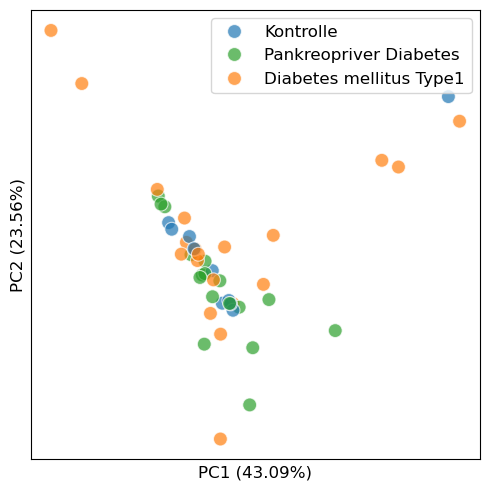

In [30]:

# Define custom color palette
custom_palette = {
    "Kontrolle": "#1f77b4",               # blue
    "Diabetes mellitus Type1": "#ff7f0e", # orange
    "Pankreopriver Diabetes": "#2ca02c"   # green
}

# Plot PCA results with custom colors
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=pca_df,
    x=pca_df.columns[0], y=pca_df.columns[1],
    hue="Type",
    palette=custom_palette,
    alpha=0.7,
    s=100
)
plt.xticks([])
plt.yticks([])

plt.xlabel(pca_df.columns[0], fontsize=12)
plt.ylabel(pca_df.columns[1], fontsize=12)
plt.title("")
plt.legend(title="", fontsize=12)
plt.tight_layout()
#plt.savefig("pca.svg")
plt.show()



#### Upsetplot / Venn diagram

In [31]:
# Define metadata columns
metadata_cols = ["index", "sample_information", "Type", "nikotin", "sex", "age_group", "AH"]

# Function to extract and clean microbial data by condition
def extract_microbial_data(df, condition_label):
    subset = df[df["sample_information"].str.startswith(condition_label)]
    microbial_data = subset.drop(columns=metadata_cols, errors='ignore')
    microbial_data = microbial_data.loc[:, (microbial_data != 0).any(axis=0)]
    microbial_data = microbial_data.loc[:, ~microbial_data.columns.str.startswith("Archaea;")]
    return microbial_data

# Create three microbial datasets
microbial_data_PDM = extract_microbial_data(df_tax, "PDM")
microbial_data_DM = extract_microbial_data(df_tax, "DM")
microbial_data_Kontrolle = extract_microbial_data(df_tax, "K")

In [32]:
# Extract microbial abundance data (exclude metadata)
list_PDM = set(microbial_data_PDM.columns)
list_DM = set(microbial_data_DM.columns)
list_Kontrolle = set(microbial_data_Kontrolle.columns)

In [33]:
common_PDM_DM = list_PDM &  list_DM

In [34]:
notcommon_PDM_DM = list_PDM ^  list_DM

# Unique to PDM
unique_PDM = list_PDM - list_DM - list_Kontrolle

# Unique to DM
unique_DM = list_DM - list_PDM - list_Kontrolle

# If you want to convert them to sorted lists for display or export:
common_PDM_DM = sorted(list(common_PDM_DM))
unique_PDM = sorted(list(unique_PDM))
unique_DM = sorted(list(unique_DM))

In [35]:
# Define metadata columns
metadata_cols = ["index", "sample_information", "Type", "nikotin", "sex", "age_group", "AH"]

microbial_data = df_tax.drop(columns=metadata_cols, errors='ignore')
microbial_data = microbial_data.loc[:, (microbial_data != 0).any(axis=0)]


def extract_microbial_data(df, condition_label):
    subset = df[df["sample_information"].str.startswith(condition_label)]
    microbial_data = subset.drop(columns=metadata_cols, errors='ignore')
    microbial_data = microbial_data.loc[:, (microbial_data != 0).any(axis=0)]
    return microbial_data

# Create three microbial datasets
microbial_data_PDM = extract_microbial_data(df_tax, "PDM")
microbial_data_DM = extract_microbial_data(df_tax, "DM")

list_PDM = set(microbial_data_PDM.columns)
list_DM = set(microbial_data_DM.columns)

common_PDM_DM = list_PDM - list_DM
# If you want to convert them to sorted lists for display or export:
common_PDM_DM = sorted(list(common_PDM_DM))

/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth

<Figure size 1000x600 with 0 Axes>

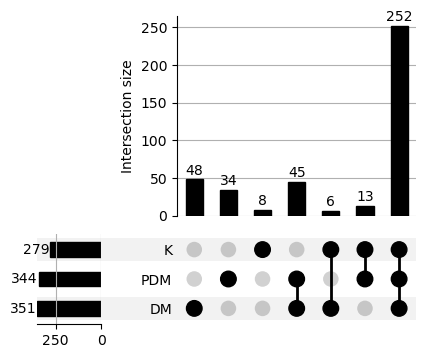

In [36]:
import pandas as pd
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt


# Assume you already have these:
# microbial_data_PDM, microbial_data_DM, microbial_data_Healthy

# Get sets of taxa present in each group
taxa_PDM = set(microbial_data_PDM.columns)
taxa_DM = set(microbial_data_DM.columns)
taxa_K = set(microbial_data_Kontrolle.columns)


# Create a list of presence/absence combinations
taxa_all = taxa_PDM | taxa_DM  | taxa_K

memberships = []
for taxon in taxa_all:
    presence = []
    if taxon in taxa_PDM:
        presence.append("PDM")
    if taxon in taxa_DM:
        presence.append("DM")
    if taxon in taxa_K:
        presence.append("K")
  
    memberships.append(presence)

# Convert to format UpSet needs
data = from_memberships(memberships)

# Plot UpSet
plt.figure(figsize=(10, 6))
UpSet(data, subset_size='count', show_counts=True).plot()
plt.title("")
plt.tight_layout()
#plt.savefig("upsetplot.svg")
plt.show()


# Unique to PDM
shared_PDM_DM_only = (taxa_PDM & taxa_DM) - taxa_K

# Unique to DM
unique_PDM = taxa_PDM - taxa_DM - taxa_K

# Unique to DM
unique_DM = taxa_DM - taxa_PDM - taxa_K

# Unique to DM
unique_K = taxa_K - taxa_DM - taxa_PDM 


#### Volcano

In [37]:
microbial_data_original = microbial_data_original.loc[:, microbial_data_original.columns != '']

In [38]:
df_filtered = microbial_data_original[microbial_data_original["Type"].isin(["pankreopriver Diabetes", "Diabetes mellitus Typ1"])].copy()
df_filtered["condition"] = df_filtered["Type"].map({"pankreopriver Diabetes": 1, "Diabetes mellitus Typ1": 0})

In [39]:
df_filtered_original = df_filtered.copy()

In [40]:
#df_filtered = df_filtered_original

In [41]:
df_filtered = df_filtered.set_index("id")

In [42]:
results = []

In [43]:
df_filtered = df_filtered.select_dtypes(include='number')


In [44]:
from patsy import dmatrix, ModelDesc, Term, EvalFactor

results = []
for taxon in df_filtered.columns:
    if taxon == 'condition':
        continue

    try:
        df_filtered[taxon] = pd.to_numeric(df_filtered[taxon], errors='coerce')

        # Safely wrap the taxon name
        formula = f"Q('{taxon}') ~ condition"

        # Fit Negative Binomial model
        model = smf.glm(formula, data=df_filtered, family=sm.families.NegativeBinomial()).fit()
        log_fold_change = model.params["condition"]
        p_value = model.pvalues["condition"]
        results.append((taxon, log_fold_change, p_value))
    except Exception as e:
        print(f"Skipping {taxon}: {e}")
        continue



/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using defau

Skipping Incertae Sedis: arg must be a list, tuple, 1-d array, or Series


/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using defau

Skipping Aggregatibacter: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Skipping Leptotrichia: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Skipping CAG-873: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using defau

Skipping CHKCI002: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using defau

Skipping Phaseolibacter: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Skipping Candidatus Stoquefichus: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Skipping Incertae Sedis: arg must be a list, tuple, 1-d array, or Series
Skipping Acetanaerobacterium: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.


/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using defau

Skipping CHKCI001: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
Skipping Incertae Sedis: arg must be a list, tuple, 1-d array, or Series


/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/kvalem/.conda/envs/scanpy/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using defau

In [45]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Taxon", "Log2 Fold Change", "p-value"])

# Adjust p-values using Benjamini-Hochberg (FDR correction)
results_df["Adjusted p-value"] = multipletests(results_df["p-value"], method="fdr_bh")[1]

# Create a Volcano Plot to visualize differential abundance results

# Define significance threshold
significance_threshold = 0.05

# Create a new column for significance labeling
results_df["Significance"] = results_df["Adjusted p-value"] < significance_threshold

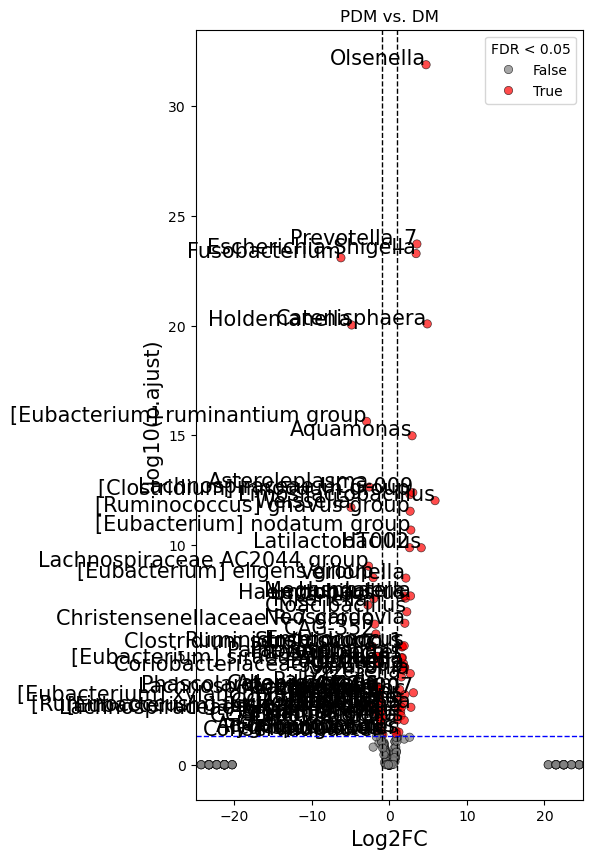

In [46]:
# Create Volcano Plot
plt.figure(figsize=(5,10))
sns.scatterplot(
    x=results_df["Log2 Fold Change"],
    y=-np.log10(results_df["Adjusted p-value"]),
    hue=results_df["Significance"],
    palette={True: "red", False: "gray"},
    edgecolor="black",
    alpha=0.7
)

# Add labels for significant points
for i, row in results_df.iterrows():
    if row["Significance"]:
        plt.text(row["Log2 Fold Change"], -np.log10(row["Adjusted p-value"]), row["Taxon"], fontsize=15, ha='right')


logfoldchange_threshold= 1
# Labels and title
plt.axhline(-np.log10(significance_threshold), linestyle="--", color="blue", linewidth=1)  # Threshold line
plt.axvline(x=-logfoldchange_threshold, linestyle="--", color="black", linewidth=1)  # Log2FC negative threshold
plt.axvline(x=logfoldchange_threshold, linestyle="--", color="black", linewidth=1)  # Log2FC positive threshold
plt.xlabel("Log2FC",fontsize=15, )
plt.ylabel("-log10(p.ajust)",fontsize=15, )
plt.title("PDM vs. DM")
plt.legend(title="FDR < 0.05", loc="upper right")
plt.xlim(-25, 25)
#plt.savefig("volcano_pdm_dn.svg")
# Show plot
plt.show()